In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="3"

# CycleGAN

#### Directory structure:
- **data/** contains the datasets.
    - **data/&lt;dataset&gt;/{train_A, train_B}/** contains training images for classes A and B.
    - **data/&lt;dataset&gt;/{test_A, test_B}/** contains testing images that are not used during training. These are useful to evaluate the generalization of the model to new data.
- **images/** stores metadata and loss information of each CycleGAN run, as well as evaluation images.
    - **images/meta_data.json** contains the settings of the run.
    - **images/loss_output.csv** contains the various losses of the model, stored after every batch.
    - **images/{train_A, train_B, test_A, test_B}** contains intermediate evaluation images for each epoch, illustrating generator performance.
    - **images/tmp.png** shows example image translations from the current moment in training. This image updates in real time and can be used to see how the training converges.
- **saved_models** stores the generator and discriminator models resulting from each run, which are saved every 20 epochs.

Tomado de:
https://github.com/brainhack101/IntroDL/blob/master/notebooks/2019/Eklund/CycleGAN.ipynb

!rm -rf __pycache__

!wget -nc https://raw.githubusercontent.com/brainhack101/IntroDL/master/notebooks/2019/Eklund/requirements-gpu.txt

!pip install -r requirements-gpu.txt

In [2]:
from keras.layers import Layer, Input, Dropout, Conv2D, Activation, add, UpSampling2D, Conv2DTranspose, Flatten
from keras_contrib.layers.normalization.instancenormalization import InstanceNormalization, InputSpec
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.core import Dense
from keras.optimizers import Adam
from keras.models import Model
from keras.engine.topology import Network

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from progress.bar import Bar
import datetime
import time
import json
import csv
import sys
import os

import keras.backend as K
import tensorflow as tf
print(tf.__version__)

Using TensorFlow backend.
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:519: FutureWarn

1.14.0


Additional functions are contained in the `helper_functions.py` file. These mostly include code for loading the data and saving the resutls.

!wget https://raw.githubusercontent.com/brainhack101/IntroDL/master/notebooks/2019/Eklund/helper_funcs.py

In [3]:
#from helper_funcs import *
from helper_funcs2 import *
#from helper_funcs3 import *

If you have multiple GPUs you can select a single one of them by setting the visible CUDA device to 0, 1, ...

#### Load data

The dataset used for the run is **data/&lt;`image_folder`&gt;**.

In [4]:
image_folder = 'brain' #skullstripped
#image_folder = 'brainv3'
#image_folder = 'brainv4' #bounded

#image_folder = 'healthy' #anomaly detection
data = load_data(subfolder=image_folder)

### Model parameters

This CycleGAN implementation allows a lot of freedom on both the training parameters and the network architecture.

In [5]:
opt = {}

# Data
opt['channels'] = data["nr_of_channels"]
opt['img_shape'] = data["image_size"] + (opt['channels'],)
print('Image shape: ', opt['img_shape'])

opt['A_train'] = data["trainA_images"]
opt['B_train'] = data["trainB_images"]
opt['A_test'] = data["testA_images"]
opt['B_test'] = data["testB_images"]
opt['testA_image_names'] = data["testA_image_names"]
opt['testB_image_names'] = data["testB_image_names"]

opt['trainA_image_names'] = data["trainA_image_names"]
opt['trainB_image_names'] = data["trainB_image_names"]

#opt['CTFOSCAL_images'] = data["CTFOSCAL_images"]
#opt['CTFOSCAL_image_names'] = data["CTFOSCAL_image_names"]
opt['CTHEALTHY_images'] = data["CTHEALTHY_images"]
opt['CTHEALTHY_image_names'] = data["CTHEALTHY_image_names"]

print(opt['A_train'].shape)
print(opt['B_train'].shape)

#print(opt['CTFOSCAL_images'].shape)
#print(len(opt['CTFOSCAL_image_names']))
print(opt['CTHEALTHY_images'].shape)
print(len(opt['CTHEALTHY_image_names']))

Image shape:  (256, 256, 1)
(502, 256, 256, 1)
(993, 256, 256, 1)
(1568, 256, 256, 1)
1568


CylceGAN can be used both on paired and unpaired data. The `paired_data` setting affects the presentation of output images as explained above.

In [6]:
#opt['paired_data'] = True
opt['paired_data'] = False

#### Training parameters
- `lambda_ABA` and `lambda_BAB` set the importance of the cycle consistency losses in relation to the adversarial loss `lambda_adversarial`
- `learning_rate_D` and `learning_rate_G` are the learning rates for the discriminators and generators respectively.
- `generator_iterations` and `discriminator_iterations` represent how many times the generators or discriminators will be trained on every batch of images. This is very useful to keep the training of both systems balanced. In this case the discriminators become successful faster than the generators, so we account for this by training the generators 3 times on every batch of images.
- `synthetic_pool_size` sets the size of the image pool used for training the discriminators. The image pool has a certain probability of returning a synthetic image from previous iterations, thus forcing the discriminator to have a certain "memory". More information on this method can be found in [this paper](https://arxiv.org/abs/1612.07828).
- `beta_1` and `beta_2` are paremeters of the [Adam](https://arxiv.org/abs/1412.6980) optimizers used on the generators and discriminators.
- `batch_size` determines the number of images used for each update of the network weights. Due to the significant memory requirements of CycleGAN it is difficult to use a large batch size. For the small example dataset values between 1-30 may be possible.
- `epochs` sets the number of training epochs. Each epoch goes through all the training images once. The number of epochs necessary to train a model is therefore dependent on both the number of training images available and the batch size.

In [7]:
# Training parameters
opt['lambda_ABA'] = 10.0  # Cyclic loss weight A_2_B
opt['lambda_BAB'] = 10.0  # Cyclic loss weight B_2_A
opt['lambda_adversarial'] = 1.0  # Weight for loss from discriminator guess on synthetic images
opt['learning_rate_D'] = 2e-4
opt['learning_rate_G'] = 2e-4
opt['generator_iterations'] = 3  # Number of generator training iterations in each training loop
opt['discriminator_iterations'] = 1  # Number of discriminator training iterations in each training loop
opt['synthetic_pool_size'] = 50  # Size of image pools used for training the discriminators
opt['beta_1'] = 0.5  # Adam parameter
opt['beta_2'] = 0.999  # Adam parameter
opt['batch_size'] = 10  # Number of images per batch
opt['epochs'] = 5  # Choose multiples of 20 since the models are saved each 20th epoch

In [8]:
# Output parameters
opt['save_models'] = True  # Save or not the generator and discriminator models
opt['save_training_img'] = True  # Save or not example training results or only tmp.png
opt['save_training_img_interval'] = 1  # Number of epoch between saves of intermediate training results
opt['self.tmp_img_update_frequency'] = 3  # Number of batches between updates of tmp.png

#### Architecture parameters
- `use_instance_normalization` is supposed to allow the selection of instance normalization or batch normalization layes. At the moment only instance normalization is implemented, so this option does not do anything.
- `use_dropout` and `use_bias` allows setting droupout layers in the generators and whether to use a bias term in the various convolutional layer in the genrators and discriminators.
- `use_linear_decay` applies linear decay on the learning rates of the generators and discriminators,   `decay_epoch`
- `use_patchgan` determines whether the discriminator evaluates the "realness" of images on a patch basis or on the whole. More information on PatchGAN can be found in [this paper](https://arxiv.org/abs/1611.07004).
- `use_resize_convolution` provides two ways to perfrom the upsampling in the generator, with significant differences in the results. More information can be found in [this article](https://distill.pub/2016/deconv-checkerboard/). Each has its advantages, and we have managed to get successful result with both methods
- `use_discriminator sigmoid` adds a sigmoid activation at the end of the discrimintator, forcing its output to the (0-1) range.

In [9]:
# Architecture parameters
opt['use_instance_normalization'] = True  # Use instance normalization or batch normalization
opt['use_dropout'] = False  # Dropout in residual blocks
opt['use_bias'] = True  # Use bias
opt['use_linear_decay'] = True  # Linear decay of learning rate, for both discriminators and generators
opt['decay_epoch'] = 100  # The epoch where the linear decay of the learning rates start
opt['use_patchgan'] = True  # PatchGAN - if false the discriminator learning rate should be decreased
opt['use_resize_convolution'] = False  # Resize convolution - instead of transpose convolution in deconvolution layers (uk) - can reduce checkerboard artifacts but the blurring might affect the cycle-consistency
opt['discriminator_sigmoid'] = True  # Add a final sigmoid activation to the discriminator

In [10]:
# Tweaks
opt['REAL_LABEL'] = 1.0  # Use e.g. 0.9 to avoid training the discriminators to zero loss

### Model architecture

#### Layer blocks
These are the individual layer blocks that are used to build the generators and discriminator. More information can be found in the appendix of the [CycleGAN paper](https://arxiv.org/abs/1703.10593).

In [11]:
# Discriminator layers
def ck(model, opt, x, k, use_normalization, use_bias):
    x = Conv2D(filters=k, kernel_size=4, strides=2, padding='same', use_bias=use_bias)(x)
    if use_normalization:
        x = model['normalization'](axis=3, center=True, epsilon=1e-5)(x, training=True)
    x = LeakyReLU(alpha=0.2)(x)
    return x

# First generator layer
def c7Ak(model, opt, x, k):
    x = Conv2D(filters=k, kernel_size=7, strides=1, padding='valid', use_bias=opt['use_bias'])(x)
    x = model['normalization'](axis=3, center=True, epsilon=1e-5)(x, training=True)
    x = Activation('relu')(x)
    return x

# Downsampling
def dk(model, opt, x, k):  # Should have reflection padding
    x = Conv2D(filters=k, kernel_size=3, strides=2, padding='same', use_bias=opt['use_bias'])(x)
    x = model['normalization'](axis=3, center=True, epsilon=1e-5)(x, training=True)
    x = Activation('relu')(x)
    return x

# Residual block
def Rk(model, opt, x0):
    k = int(x0.shape[-1])

    # First layer
    x = ReflectionPadding2D((1,1))(x0)
    x = Conv2D(filters=k, kernel_size=3, strides=1, padding='valid', use_bias=opt['use_bias'])(x)
    x = model['normalization'](axis=3, center=True, epsilon=1e-5)(x, training=True)
    x = Activation('relu')(x)

    if opt['use_dropout']:
        x = Dropout(0.5)(x)

    # Second layer
    x = ReflectionPadding2D((1, 1))(x)
    x = Conv2D(filters=k, kernel_size=3, strides=1, padding='valid', use_bias=opt['use_bias'])(x)
    x = model['normalization'](axis=3, center=True, epsilon=1e-5)(x, training=True)
    # Merge
    x = add([x, x0])

    return x

# Upsampling
def uk(model, opt, x, k):
    # (up sampling followed by 1x1 convolution <=> fractional-strided 1/2)
    if opt['use_resize_convolution']:
        x = UpSampling2D(size=(2, 2))(x)  # Nearest neighbor upsampling
        x = ReflectionPadding2D((1, 1))(x)
        x = Conv2D(filters=k, kernel_size=3, strides=1, padding='valid', use_bias=opt['use_bias'])(x)
    else:
        x = Conv2DTranspose(filters=k, kernel_size=3, strides=2, padding='same', use_bias=opt['use_bias'])(x)  # this matches fractionally stided with stride 1/2
    x = model['normalization'](axis=3, center=True, epsilon=1e-5)(x, training=True)
    x = Activation('relu')(x)
    return x

#### Architecture functions

In [12]:
def build_discriminator(model, opt, name=None):
    # Input
    input_img = Input(shape=opt['img_shape'])

    # Layers 1-4
    x = ck(model, opt, input_img, 64, False, True) #  Instance normalization is not used for this layer)
    x = ck(model, opt, x, 128, True, opt['use_bias'])
    x = ck(model, opt, x, 256, True, opt['use_bias'])
    x = ck(model, opt, x, 512, True, opt['use_bias'])

    # Layer 5: Output
    if opt['use_patchgan']:
        x = Conv2D(filters=1, kernel_size=4, strides=1, padding='same', use_bias=True)(x)
    else:
        x = Flatten()(x)
        x = Dense(1)(x)

    if opt['discriminator_sigmoid']:
        x = Activation('sigmoid')(x)

    return Model(inputs=input_img, outputs=x, name=name)

def build_generator(model, opt, name=None):
    # Layer 1: Input
    input_img = Input(shape=opt['img_shape'])
    x = ReflectionPadding2D((3, 3))(input_img)
    x = c7Ak(model, opt, x, 32)

    # Layer 2-3: Downsampling
    x = dk(model, opt, x, 64)
    x = dk(model, opt, x, 128)

    # Layers 4-12: Residual blocks
    for _ in range(4, 13):
        x = Rk(model, opt, x)

    # Layer 13:14: Upsampling
    x = uk(model, opt, x, 64)
    x = uk(model, opt, x, 32)

    # Layer 15: Output
    x = ReflectionPadding2D((3, 3))(x)
    x = Conv2D(opt['channels'], kernel_size=7, strides=1, padding='valid', use_bias=True)(x)
    x = Activation('tanh')(x)

    return Model(inputs=input_img, outputs=x, name=name)

#### CasNet generator

In [13]:
#@title Generator
from keras import layers

def u_block(input_tensor, 
            encoder_num_filters=[64, 128, 256, 512, 512, 512, 512, 512],
            decoder_num_filters=[512, 1024, 1024, 1024, 1024, 512, 256, 128],
            use_instance_norm=True,
            block_prefix=''):
    
    x = input_tensor
    encoder_blocks_outputs = []
    
    # Encoder path.
    for i, num_filters in enumerate(encoder_num_filters):
        x = layers.Conv2D(num_filters, 
                          kernel_size=4, 
                          strides=2, 
                          padding='same', 
                          name=f'{block_prefix}_EncoderBlock{i+1}-Conv')(x)
        if use_instance_norm:
            x = InstanceNormalization(name=f'{block_prefix}_EncoderBlock{i+1}-Instancenorm')(x)
        else:
            x = layers.BatchNormalization(name=f'{block_prefix}_EncoderBlock{i+1}-Batchnorm')(x)
        x = layers.Activation('relu', name=f'{block_prefix}_EncoderBlock{i+1}-ReLU')(x)
        
        # Append the encoder blocks outputs, except for the last one.
        if i != len(encoder_num_filters) - 1: 
            encoder_blocks_outputs.append(x)

    # Decoder path.
    for i, num_filters in enumerate(decoder_num_filters):
        x = layers.Conv2DTranspose(
            num_filters, 
            kernel_size=(4, 4), 
            strides=(2, 2), 
            padding='same',
            name=f'{block_prefix}_DecoderBlock{i+1}-TransposedConv'
        )(x)
        x = layers.Activation('relu', name=f'{block_prefix}_DecoderBlock{i+1}-ReLU')(x)

        # All the decoder blocks have concatenate the encoder block output with
        # the same spatial dimentions except for the last one.
        if i != len(decoder_num_filters) - 1: 
            x = layers.Concatenate(
                name=f'{block_prefix}_DecoderBlock{i+1}-Concat'
            )([encoder_blocks_outputs[-(i + 1)], x])

    # Last operation: 1x1 conv to map the image to the input n_channels.
    x = layers.Conv2D(1,   #input_tensor.shape[-1]
                      kernel_size=(1, 1), 
                      name=f'{block_prefix}_Decoder-Conv1x1')(x)
    output = layers.Activation('tanh', name=f'{block_prefix}_Decoder-Tanh')(x)

    return output

def build_casnet_generator(input_shape=(256, 256, 1), 
                           n_blocks=2, 
                           use_instance_norm=True,
                           name=None):
    """Create a CasNet Generator using UBlocks"""
    input_tensor = Input(shape=input_shape)
    x = input_tensor
    for i in range(n_blocks):
        x = u_block(x, block_prefix=f'UBlock{i+1}', use_instance_norm=use_instance_norm)
    
    return Model(inputs=input_tensor, outputs=x, name=name)

#### Loss functions
The discriminators use MSE loss. The generators use MSE for the adversarial losses and MAE for the cycle consistency losses.

In [14]:
# Mean squared error
def mse(y_true, y_pred):
    loss = tf.reduce_mean(tf.squared_difference(y_pred, y_true))
    return loss

# Mean absolute error
def mae(y_true, y_pred):
    loss = tf.reduce_mean(tf.abs(y_pred - y_true))
    return loss

#### Build CycleGAN model

In [15]:
model = {}

# Normalization
model['normalization'] = InstanceNormalization

# Optimizers
model['opt_D'] = Adam(opt['learning_rate_D'], opt['beta_1'], opt['beta_2'])
model['opt_G'] = Adam(opt['learning_rate_G'], opt['beta_1'], opt['beta_2'])

# Build discriminators
D_A = build_discriminator(model, opt, name='D_A')
D_B = build_discriminator(model, opt, name='D_B')

# Define discriminator models
image_A = Input(shape=opt['img_shape'])
print(image_A.shape)
image_B = Input(shape=opt['img_shape'])
guess_A = D_A(image_A)
guess_B = D_B(image_B)
model['D_A'] = Model(inputs=image_A, outputs=guess_A, name='D_A_model')
model['D_B'] = Model(inputs=image_B, outputs=guess_B, name='D_B_model')

# Compile discriminator models
loss_weights_D = [0.5]  # 0.5 since we train on real and synthetic images
model['D_A'].compile(optimizer=model['opt_D'],
                 loss=mse,
                 loss_weights=loss_weights_D)
model['D_B'].compile(optimizer=model['opt_D'],
                 loss=mse,
                 loss_weights=loss_weights_D)

# Use containers to make a static copy of discriminators, used when training the generators
model['D_A_static'] = Network(inputs=image_A, outputs=guess_A, name='D_A_static_model')
model['D_B_static'] = Network(inputs=image_B, outputs=guess_B, name='D_B_static_model')

# Do not update discriminator weights during generator training
model['D_A_static'].trainable = False
model['D_B_static'].trainable = False

# Build generators
#model['G_A2B'] = build_generator(model, opt, name='G_A2B_model')
#model['G_B2A'] = build_generator(model, opt, name='G_B2A_model')

model['G_A2B'] = build_casnet_generator(input_shape=(256,256,1), n_blocks=1, name='G_A2B_model')
model['G_B2A'] = build_casnet_generator(input_shape=(256,256,1), n_blocks=1, name='G_B2A_model')

print("G_A2B")
#model['G_A2B'].summary()
#print("G_B2A")
#model['G_B2A'].summary()

# Define full CycleGAN model, used for training the generators
real_A = Input(shape=opt['img_shape'], name='real_A')
real_B = Input(shape=opt['img_shape'], name='real_B')
synthetic_B = model['G_A2B'](real_A)
synthetic_A = model['G_B2A'](real_B)
dB_guess_synthetic = model['D_B_static'](synthetic_B)
dA_guess_synthetic = model['D_A_static'](synthetic_A)
reconstructed_A = model['G_B2A'](synthetic_B)
reconstructed_B = model['G_A2B'](synthetic_A)

# Compile full CycleGAN model
model_outputs = [reconstructed_A, reconstructed_B,
                 dB_guess_synthetic, dA_guess_synthetic]
compile_losses = [mae, mae,
                  mse, mse]
compile_weights = [opt['lambda_ABA'], opt['lambda_BAB'],
                   opt['lambda_adversarial'], opt['lambda_adversarial']]

model['G_model'] = Model(inputs=[real_A, real_B],
                     outputs=model_outputs,
                     name='G_model')

model['G_model'].compile(optimizer=model['opt_G'],
                     loss=compile_losses,
                     loss_weights=compile_weights)

W0823 14:10:45.891675 140653810726720 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0823 14:10:45.893510 140653810726720 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0823 14:10:45.968999 140653810726720 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0823 14:10:47.095298 140653810726720 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.



(?, 256, 256, 1)
G_A2B


#### Folders and configuration

In [ ]:
opt['date_time'] = time.strftime('%Y%m%d-%H%M%S', time.localtime()) + '-' + image_folder

# Output folder for run data and images
opt['out_dir'] = os.path.join('images', opt['date_time'])
if not os.path.exists(opt['out_dir']):
    os.makedirs(opt['out_dir'])

# Output folder for saved models
if opt['save_models']:
    opt['model_out_dir'] = os.path.join('saved_models', opt['date_time'])
    if not os.path.exists(opt['model_out_dir']):
        os.makedirs(opt['model_out_dir'])

write_metadata_to_JSON(model, opt)

# Don't pre-allocate GPU memory; allocate as-needed
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
K.tensorflow_backend.set_session(tf.Session(config=config))

### Training function

In [ ]:
def train(model, opt):

    def run_training_batch():

        # ======= Discriminator training ======
        # Generate batch of synthetic images
        synthetic_images_B = model['G_A2B'].predict(real_images_A)
        synthetic_images_A = model['G_B2A'].predict(real_images_B)
        synthetic_images_B = synthetic_pool_B.query(synthetic_images_B)
        synthetic_images_A = synthetic_pool_A.query(synthetic_images_A)

        # Train discriminators on batch
        D_loss = []
        for _ in range(opt['discriminator_iterations']):
            D_A_loss_real = model['D_A'].train_on_batch(x=real_images_A, y=ones)
            D_B_loss_real = model['D_B'].train_on_batch(x=real_images_B, y=ones)
            D_A_loss_synthetic = model['D_A'].train_on_batch(x=synthetic_images_A, y=zeros)
            D_B_loss_synthetic = model['D_B'].train_on_batch(x=synthetic_images_B, y=zeros)
            D_A_loss = D_A_loss_real + D_A_loss_synthetic
            D_B_loss = D_B_loss_real + D_B_loss_synthetic
            D_loss.append(D_A_loss + D_B_loss)

        # ======= Generator training ==========
        target_data = [real_images_A, real_images_B, ones, ones]  # Reconstructed images need to match originals, discriminators need to predict ones

        # Train generators on batch
        G_loss = []
        for _ in range(opt['generator_iterations']):
            G_loss.append(model['G_model'].train_on_batch(
                x=[real_images_A, real_images_B], y=target_data))

        # =====================================

        # Update learning rates
        if opt['use_linear_decay'] and epoch >= opt['decay_epoch']:
            update_lr(model['D_A'], decay_D)
            update_lr(model['D_B'], decay_D)
            update_lr(model['G_model'], decay_G)

        # Store training losses
        D_A_losses.append(D_A_loss)
        D_B_losses.append(D_B_loss)
        D_losses.append(D_loss[-1])

        ABA_reconstruction_loss = G_loss[-1][1]
        BAB_reconstruction_loss = G_loss[-1][2]
        reconstruction_loss = ABA_reconstruction_loss + BAB_reconstruction_loss
        G_AB_adversarial_loss = G_loss[-1][3]
        G_BA_adversarial_loss = G_loss[-1][4]

        ABA_reconstruction_losses.append(ABA_reconstruction_loss)
        BAB_reconstruction_losses.append(BAB_reconstruction_loss)
        reconstruction_losses.append(reconstruction_loss)
        G_AB_adversarial_losses.append(G_AB_adversarial_loss)
        G_BA_adversarial_losses.append(G_BA_adversarial_loss)
        G_losses.append(G_loss[-1][0])

        # Print training status
        print('\n')
        print('Epoch ---------------------', epoch, '/', opt['epochs'])
        print('Loop index ----------------', loop_index + 1, '/', nr_im_per_epoch)
        if opt['discriminator_iterations'] > 1:
            print('  Discriminator losses:')
            for i in range(opt['discriminator_iterations']):
                print('D_loss', D_loss[i])
        if opt['generator_iterations'] > 1:
            print('  Generator losses:')
            for i in range(opt['generator_iterations']):
                print('G_loss', G_loss[i])
        print('  Summary:')
        print('D_lr:', K.get_value(model['D_A'].optimizer.lr))
        print('G_lr', K.get_value(model['G_model'].optimizer.lr))
        print('D_loss: ', D_loss[-1])
        print('G_loss: ', G_loss[-1][0])
        print('reconstruction_loss: ', reconstruction_loss)
        print_ETA(opt, start_time, epoch, nr_im_per_epoch, loop_index)
        sys.stdout.flush()

        if loop_index % 3*opt['batch_size'] == 0:
            # Save temporary images continously
            save_tmp_images(model, opt, real_images_A[0], real_images_B[0],
                                 synthetic_images_A[0], synthetic_images_B[0])

    # ======================================================================
    # Begin training
    # ======================================================================
    if opt['save_training_img'] and not os.path.exists(os.path.join(opt['out_dir'], 'train_A')):
        os.makedirs(os.path.join(opt['out_dir'], 'train_A'))
        os.makedirs(os.path.join(opt['out_dir'], 'train_B'))
        os.makedirs(os.path.join(opt['out_dir'], 'test_A'))
        os.makedirs(os.path.join(opt['out_dir'], 'test_B'))

    D_A_losses = []
    D_B_losses = []
    D_losses = []

    ABA_reconstruction_losses = []
    BAB_reconstruction_losses = []
    reconstruction_losses = []
    G_AB_adversarial_losses = []
    G_BA_adversarial_losses = []
    G_losses = []

    # Image pools used to update the discriminators
    synthetic_pool_A = ImagePool(opt['synthetic_pool_size'])
    synthetic_pool_B = ImagePool(opt['synthetic_pool_size'])

    # Labels used for discriminator training
    label_shape = (opt['batch_size'],) + model['D_A'].output_shape[1:]
    ones = np.ones(shape=label_shape) * opt['REAL_LABEL']
    zeros = ones * 0

    # Linear learning rate decay
    if opt['use_linear_decay']:
        decay_D, decay_G = get_lr_linear_decay_rate(opt)

    nr_train_im_A = opt['A_train'].shape[0]
    nr_train_im_B = opt['B_train'].shape[0]
    nr_im_per_epoch = int(np.ceil(np.max((nr_train_im_A, nr_train_im_B)) / opt['batch_size']) * opt['batch_size'])

    # Start stopwatch for ETAs
    start_time = time.time()
    timer_started = False

    for epoch in range(1, opt['epochs'] + 1):
        # random_order_A = np.random.randint(nr_train_im_A, size=nr_im_per_epoch)
        # random_order_B = np.random.randint(nr_train_im_B, size=nr_im_per_epoch)

        random_order_A = np.concatenate((np.random.permutation(nr_train_im_A),
                                         np.random.randint(nr_train_im_A, size=nr_im_per_epoch - nr_train_im_A)))
        random_order_B = np.concatenate((np.random.permutation(nr_train_im_B),
                                         np.random.randint(nr_train_im_B, size=nr_im_per_epoch - nr_train_im_B)))

        # Train on image batch
        for loop_index in range(0, nr_im_per_epoch, opt['batch_size']):
            indices_A = random_order_A[loop_index:loop_index + opt['batch_size']]
            indices_B = random_order_B[loop_index:loop_index + opt['batch_size']]

            real_images_A = opt['A_train'][indices_A]
            real_images_B = opt['B_train'][indices_B]

            # Train on image batch
            run_training_batch()

            # Start timer after first (slow) iteration has finished
            if not timer_started:
                start_time = time.time()
                timer_started = True

        # Save training images
        if opt['save_training_img'] and epoch % opt['save_training_img_interval'] == 0:
            print('\n', '\n', '-------------------------Saving images for epoch', epoch, '-------------------------', '\n', '\n')
            save_epoch_images(model, opt, epoch)

        # Save model
        if opt['save_models'] and epoch % 1 == 0:
            save_model(opt, model['D_A'], epoch)
            save_model(opt, model['D_B'], epoch)
            save_model(opt, model['G_A2B'], epoch)
            save_model(opt, model['G_B2A'], epoch)

        # Save training history
        training_history = {
            'DA_losses': D_A_losses,
            'DB_losses': D_B_losses,
            'G_AB_adversarial_losses': G_AB_adversarial_losses,
            'G_BA_adversarial_losses': G_BA_adversarial_losses,
            'ABA_reconstruction_losses': ABA_reconstruction_losses,
            'BAB_reconstruction_losses': BAB_reconstruction_losses,
            'reconstruction_losses': reconstruction_losses,
            'D_losses': D_losses,
            'G_losses': G_losses}
        write_loss_data_to_file(opt, training_history)

### Train CycleGAN

In [ ]:
train(model, opt)

### Load weights

In [16]:
#folder = "20211209-235929-brain" #2ublocks
#folder = "20211213-234440-brain" #1ublocks
#folder = "20211213-234440-brain" #1ublocks 6epochs ---> embebidos
#folder = "20211214-223746-brain" #2ublocks 2epochs
#folder = "20211214-232746-brain" #2ublocks 10epochs ---> embebidos
#folder = "20211215-141924-brain" #2ublocks 4epochs 4g1d
#folder = "20211215-175957-brain" #2ublocks 4epochs 3g2d

#folder = "20220127-181445-brain" #ANOMALY APPROACH 1ublocks 5 epochs (3 epochs best)
#folder = "20220324-202120-healthy" #ANOMALY APPROACH 1ublocks 5 epochs (1 epoch best - new healthy MRI trainB testB)

folder = "20220112-215315-brain" #1ublocks 10epochs (mejor valor con 1 epochs, OJO) #CT SKULL-STRIPPED
#folder = "20220316-163428-brainv3" #1ublocks 5epochs (mejor valor con 1 epochs, OJO) #CT
#folder = "20220316-172625-brainv4" #1ublocks 10epochs (mejor valor con 1 epochs, OJO) #CT SEMI-BOUNDED
#folder = "20220316-213350-brainv4" #1ublocks 10epochs (mejor valor con 1 epochs, OJO) #CT BOUNDED

ep = 1
checkpoint_path1 = "saved_models/"+folder+"/G_A2B_model_weights_epoch_"+str(ep)+".hdf5"
checkpoint_path2 = "saved_models/"+folder+"/G_B2A_model_weights_epoch_"+str(ep)+".hdf5"
model["G_A2B"].load_weights(checkpoint_path1)
model["G_B2A"].load_weights(checkpoint_path2)

W0823 14:11:25.807731 140653810726720 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:174: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.

W0823 14:11:25.810276 140653810726720 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:181: The name tf.ConfigProto is deprecated. Please use tf.compat.v1.ConfigProto instead.



(502, 256, 256, 1)
(993, 256, 256, 1)


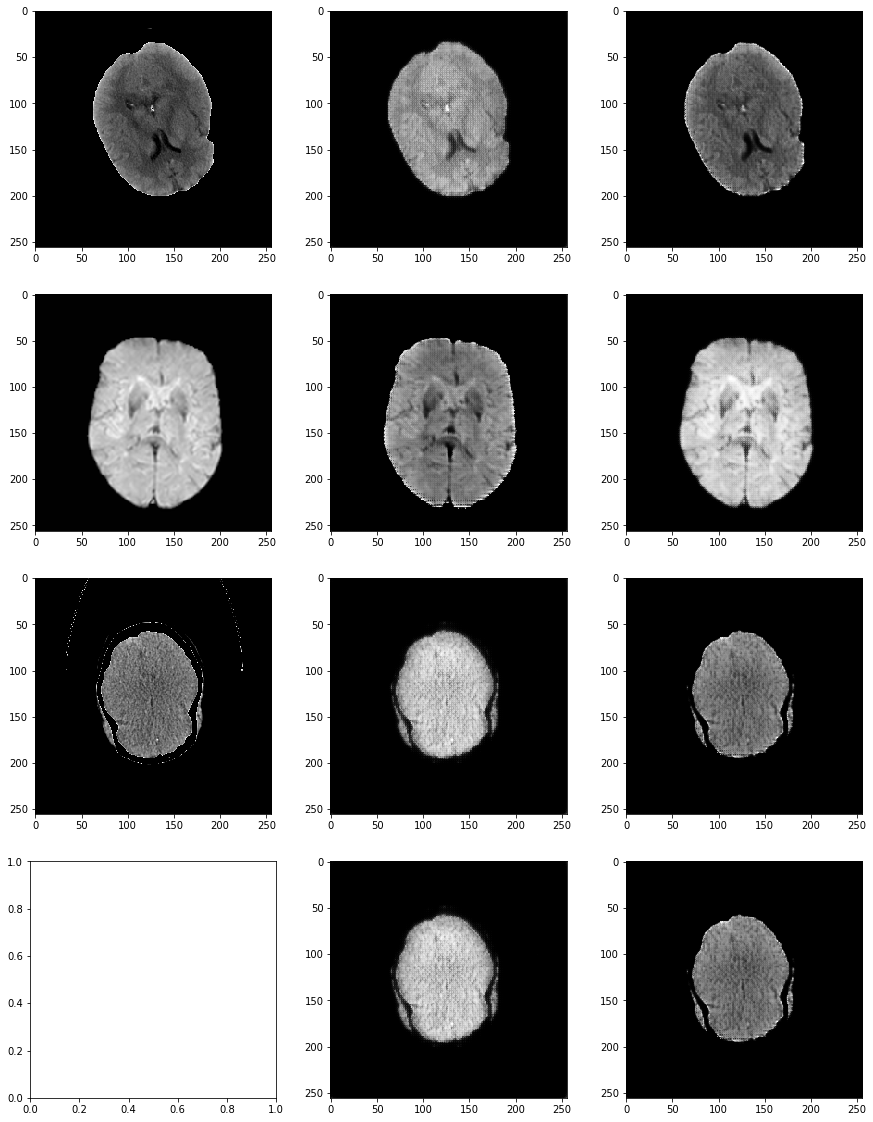

In [17]:
test_images_A = opt['A_train'][1]
test_images_B = opt['B_train'][18]
print(opt['A_train'].shape)
print(opt['B_train'].shape)

synthetic_images_B = model['G_A2B'].predict(test_images_A[np.newaxis,:])
reconstructed_image_A = model['G_B2A'].predict(synthetic_images_B)

synthetic_images_A = model['G_B2A'].predict(test_images_B[np.newaxis,:])
reconstructed_image_B = model['G_A2B'].predict(synthetic_images_A)

plt.figure(figsize=(15,20))
plt.subplot(4,3,1)
plt.imshow(test_images_A[:,:,0], cmap="gray")
plt.subplot(4,3,2)
plt.imshow(synthetic_images_B[0,:,:,0], cmap="gray")
plt.subplot(4,3,3)
plt.imshow(reconstructed_image_A[0,:,:,0], cmap="gray")

plt.subplot(4,3,4)
plt.imshow(test_images_B[:,:,0], cmap="gray")
plt.subplot(4,3,5)
plt.imshow(synthetic_images_A[0,:,:,0], cmap="gray")
plt.subplot(4,3,6)
plt.imshow(reconstructed_image_B[0,:,:,0], cmap="gray")


CTHEALTHY_images_A = opt['CTHEALTHY_images'][1]

synthetic_images_B = model['G_A2B'].predict(CTHEALTHY_images_A[np.newaxis,:])
reconstructed_image_A = model['G_B2A'].predict(synthetic_images_B)

plt.subplot(4,3,7)
plt.imshow(CTHEALTHY_images_A[:,:,0], cmap="gray")
plt.subplot(4,3,8)
plt.imshow(synthetic_images_B[0,:,:,0], cmap="gray")
plt.subplot(4,3,9)
plt.imshow(reconstructed_image_A[0,:,:,0], cmap="gray")


#CTFOSCAL_images_A = opt['CTFOSCAL_images'][10]

#synthetic_images_B = model['G_A2B'].predict(CTFOSCAL_images_A[np.newaxis,:])
#reconstructed_image_A = model['G_B2A'].predict(synthetic_images_B)

plt.subplot(4,3,10)
#plt.imshow(CTFOSCAL_images_A[:,:,0], cmap="gray")
plt.subplot(4,3,11)
plt.imshow(synthetic_images_B[0,:,:,0], cmap="gray")
plt.subplot(4,3,12)
plt.imshow(reconstructed_image_A[0,:,:,0], cmap="gray")
plt.show()

# Loading foscal data

In [33]:
import nibabel as nib
import SimpleITK as sitk
from scipy.ndimage import rotate
from scipy import misc
import sys
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from sklearn.decomposition import PCA
from typing import Tuple, Callable
import cv2

In [40]:
def load_nii(f):
    img = nib.load(f)
    vol = img.get_fdata()
    nvol = min_max_normalization(vol)
    rnvol = resize_data(nvol, (256,256))
    rnvol = rnvol.transpose(2,0,1)
    rnvol = np.expand_dims(rnvol,axis=-1)
    return rnvol

def min_max_normalization(data: np.ndarray) -> np.ndarray:
    """Returns a min-max normalized data array. The values for the
    normalized array will lie between 0 and 1.

    Args:
        data (np.ndarray): array to be normalized

    Returns:
        np.ndarray: Normalized data
    """
    min = data.min()
    max = data.max()
    return (data - min) / (max - min)

def resize_data(data: np.ndarray, target_size: Tuple[int, int]) -> np.ndarray:
    """Function to resize medical images except the manually delineated
    masks. This function applies a bilinear interpolation to all the
    channels/slices in `data` to obtain a resized version.

    Args:
        data (np.ndarray): medical images to resize.
        target_size (Tuple[int, int]): target dimensionality

    Returns:
        np.ndarray: resized data
    """
    resized_data = cv2.resize(data, target_size)
    return resized_data

In [137]:
files = ["/data/Datasets/stroke/ggarzon/registered-v1/ACV-067/SER00002_CEREBRAL_5&10mm_20220116175119_11.nii",
         "/data/Datasets/stroke/ggarzon/registered-v1/ACV-067/SER00002_CEREBRAL_HELICAL_20220117063038_9.nii",
         "/data/Datasets/stroke/ggarzon/registered-v1/ACV-067/SER00002_CEREBRAL_HELICAL_20220120000239_9.nii",
         "/data/Datasets/stroke/ggarzon/registered-v1/ACV-067/SER00002_CEREBRAL_HELICAL_20220123235341_9.nii",
         
         #"/data/Datasets/stroke/ggarzon/registered-v1/ACV-039/SER00004_CEREBRAL_5&10mm_20211209200751_15.nii",
         #"/data/Datasets/stroke/ggarzon/registered-v1/ACV-039/SER00002_CEREBRAL_5&10mm_20211210054737_11.nii",
         #"/data/Datasets/stroke/ggarzon/registered-v1/ACV-039/SER00003_CEREBRAL_5&10mm_20211213195015_11.nii",
    
         #"/data/Datasets/stroke/ggarzon/registered-v1/ACV-045/SER00004_CEREBRAL_5&10mm_20211213113042_25.nii",
         #"/data/Datasets/stroke/ggarzon/registered-v1/ACV-045/SER00002_CEREBRAL_5&10mm_20211214050718_2.nii",
         #"/data/Datasets/stroke/ggarzon/registered-v1/ACV-045/SER00002_CEREBRAL_5&10mm_20211218170430_11.nii",
    
         #"/data/Datasets/stroke/ggarzon/registered-v1/ACV-029/SER00005_CEREBRAL_5&10mm_20211112075237_17.nii",
         #"/data/Datasets/stroke/ggarzon/registered-v1/ACV-029/SER00002_CEREBRAL_5&10mm_20211113053643_11.nii",
         #"/data/Datasets/stroke/ggarzon/registered-v1/ACV-029/SER00002_CEREBRAL_5&10mm_20211228124117_11.nii",
         
         #"/data/Datasets/stroke/ggarzon/registered-v1/ACV-083/SER00002_CEREBRAL_5&10mm_20220220222840_2.nii",
         #"/data/Datasets/stroke/ggarzon/registered-v1/ACV-083/SER00002_CEREBRAL_5&10mm_20220221061826_9.nii",
         #"/data/Datasets/stroke/ggarzon/registered-v1/ACV-083/SER00002_CEREBRAL_5&10mm_20220221061826_9.nii",
         
         #"/data/Datasets/stroke/ggarzon/registered-v1/ACV-086/SER00002_CEREBRAL_HELICAL_20220306054817_9.nii",
         #"/data/Datasets/stroke/ggarzon/registered-v1/ACV-086/SER00002_CEREBRAL_HELICAL_20220309060531_9.nii",
         #"/data/Datasets/stroke/ggarzon/registered-v1/ACV-086/SER00002_CEREBRAL_HELICAL_20220311095028_9.nii",
         #"/data/Datasets/stroke/ggarzon/registered-v1/ACV-086/SER00002_CEREBRAL_HELICAL_20220315060229_9_Eq_1.nii",
         
         #"/data/Datasets/stroke/ggarzon/registered-v1/ACV-089/SER00002_CEREBRAL_5&10mm_20220311110827_11.nii",
         #"/data/Datasets/stroke/ggarzon/registered-v1/ACV-089/SER00002_CEREBRAL_5&10mm_20220312054916_11.nii",
         #"/data/Datasets/stroke/ggarzon/registered-v1/ACV-089/SER00002_CEREBRAL_5&10mm_20220313060240_3.nii",
         
         #"/data/Datasets/stroke/ggarzon/registered-v1/ACV-090/SER00001_CEREBRAL_5&10mm_20220318110817_15.nii",
         #"/data/Datasets/stroke/ggarzon/registered-v1/ACV-090/SER00002_CEREBRAL_5&10mm_20220319060532_9.nii",
         #"/data/Datasets/stroke/ggarzon/registered-v1/ACV-090/SER00002_CEREBRAL_5&10mm_20220325061720_13.nii",
        ]

img = load_nii(files[0])

In [138]:
img.shape

(20, 256, 256, 1)

In [139]:
imglist = []

for e,i in enumerate(files):
    img = load_nii(i)
    synthetic_images_foscal = model['G_A2B'].predict(img)
    embfoscal = capa_o.predict(synthetic_images_foscal)
    pca = PCA(n_components=2)
    compfoscal = pca.fit_transform(embfoscal[:,0,0,:])
    imglist.append(compfoscal)

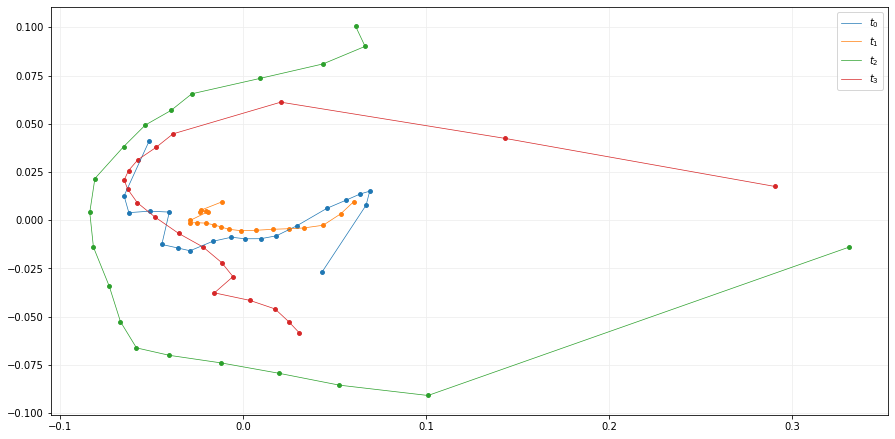

In [140]:
fig, ax = plt.subplots()
fig.set_size_inches(15,7.5,forward=True)
for i in range(len(files)):
    ax.scatter(np.array(imglist)[i][:,0], np.array(imglist)[i][:,1], s=15)
    ax.plot(np.array(imglist)[i][:,0], np.array(imglist)[i][:,1], linewidth=0.7, label="$t_"+str(i)+"$")
ax.legend()
ax.grid(color='#EEEEEE')
#plt.xticks([])
#plt.yticks([])
#plt.xlim((0,2))
#plt.ylim((-1,0))

fig.savefig('foscal-acv067-reg.pdf', bbox_inches='tight')
#fig.savefig('foscal-acv039-reg.pdf', bbox_inches='tight')
#fig.savefig('foscal-acv045-reg.pdf', bbox_inches='tight')
#fig.savefig('foscal-acv029-reg.pdf', bbox_inches='tight')
#fig.savefig('foscal-acv083-reg.pdf', bbox_inches='tight')
#fig.savefig('foscal-acv086-reg.pdf', bbox_inches='tight')
#fig.savefig('foscal-acv089-reg.pdf', bbox_inches='tight')
#fig.savefig('foscal-acv090-reg.pdf', bbox_inches='tight')
ax.set_axisbelow(True)
fig.show()

# Training data

In [18]:
import keras
import seaborn as sns

capa_o = keras.models.Model(inputs=model["G_A2B"].get_input_at(0), outputs=model["G_A2B"].get_layer('UBlock1_EncoderBlock8-ReLU').output)
capa_o2 = keras.models.Model(inputs=model["G_B2A"].get_input_at(0), outputs=model["G_B2A"].get_layer('UBlock1_EncoderBlock8-ReLU').output)

In [19]:
opt['A_train'].shape

(502, 256, 256, 1)

In [19]:
synthetic_images_B = model['G_A2B'].predict(opt['A_train'])

print(opt['trainA_image_names'][0])

emb = capa_o.predict(synthetic_images_B)
print("emb", emb[:,0,0,:].shape, emb.shape)

emb2 = capa_o2.predict(opt['B_train'])
print("emb2", emb2[:,0,0,:].shape)

339336-frame1.png
emb (502, 512) (502, 1, 1, 512)
emb2 (993, 512)


In [20]:
synthetic_images_Btest = model['G_A2B'].predict(opt['A_test'])
embtest = capa_o.predict(synthetic_images_Btest)
print("embtest", embtest[:,0,0,:].shape, embtest.shape)

embtest (282, 512) (282, 1, 1, 512)


In [21]:
synthetic_images_B_CTHEALTHY = model['G_A2B'].predict(opt['CTHEALTHY_images'])
#synthetic_images_B_CTFOSCAL = model['G_A2B'].predict(opt['CTFOSCAL_images'])

print(opt['CTHEALTHY_image_names'][0])
#print(opt['CTFOSCAL_image_names'][0])

emb3 = capa_o2.predict(synthetic_images_B_CTHEALTHY)
print("emb3", emb3[:,0,0,:].shape)

#emb4 = capa_o2.predict(synthetic_images_B_CTFOSCAL)
#print("emb4", emb4[:,0,0,:].shape)

sub-0001_ct-frame152.png
emb3 (1568, 512)


## Loading Chronic patients

In [27]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
comp = pca.fit_transform(emb[:,0,0,:])

pca2 = PCA(n_components=2)
comp2 = pca2.fit_transform(emb2[:,0,0,:])

In [28]:
from sklearn.decomposition import PCA

pca3 = PCA(n_components=2)
comp3 = pca3.fit_transform(emb3[:,0,0,:])

#pca4 = PCA(n_components=2)
#comp4 = pca4.fit_transform(emb4[:,0,0,:])

In [29]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
comptest = pca.fit_transform(embtest[:,0,0,:])

### ISLES 2018 - trainA (anomaly approach)

### ISLES 2018 - testA (anomaly approach)

### FOSCAL (anomaly approach)

# Synthetic MRI space

In [30]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os

d = pd.read_csv("data/xxx2.csv")

mb_list = []
mb_synth_ns = []
mb_synth_stroke = []

emb_s = []
emb_ns = []

#data_isles2018["t_image_names"]

print(type(comp))
for i in range(len(opt['trainA_image_names'])):
#for i in range(len(data_isles2018["t_image_names"])):
    #fname, comp[i,0], comp[i,1], maskbin
    mb_list.append(list(d.loc[d["CT"] == opt['trainA_image_names'][i]]["maskbin"])[0])
    if (list(d.loc[d["CT"] == opt['trainA_image_names'][i]]["maskbin"])[0]==0):
        mb_synth_ns.append([comp[i,0], comp[i,1]])
        emb_ns.append(emb[i,0,0,:])
    else:
        mb_synth_stroke.append([comp[i,0], comp[i,1]])
        emb_s.append(emb[i,0,0,:])

mb_synth_ns = np.array(mb_synth_ns)
mb_synth_stroke = np.array(mb_synth_stroke)

<class 'numpy.ndarray'>


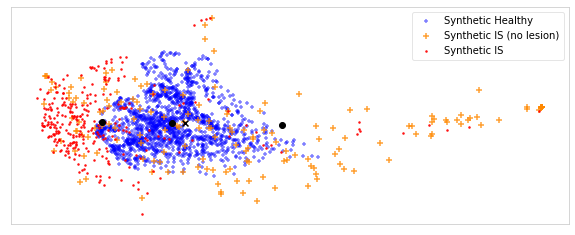

In [31]:
#d = {'files': data_isles2018["t_image_names"], 'maskbin': mb_list, 'x_pca': comp[:,0], 'y_pca': comp[:,1]}
#d = pd.DataFrame(data=d)

#sns.reset_defaults()
plt.figure(figsize=(10,4))
plt.rcParams['axes.edgecolor'] = '#CCCCCC'


plt.scatter(comp3[:,0], comp3[:,1], label="Synthetic Healthy", alpha=0.5, s=10, marker="+", color="#0000FF")
plt.scatter(mb_synth_ns[:,0], mb_synth_ns[:,1], label="Synthetic IS (no lesion)", alpha=0.8, s=30, marker="+", color="#FF8800")
plt.scatter(mb_synth_stroke[:,0], mb_synth_stroke[:,1], label="Synthetic IS", alpha=0.8, s=10, marker=".", color="#FF0000")

#plt.scatter(comptest[:,0], comptest[:,1], label="Synthetic IS test", alpha=1, s=10, marker=".", color="#000000")

#plt.scatter(comp[:,0], comp[:,1], label="Synthetic MRI CTHEALTHY", alpha=0.8, s=5, color="#0000FF")
#plt.scatter(comp4[:,0], comp4[:,1], label="Synthetic FOSCAL", alpha=0.6, s=20, color="#555555", marker="x")
#plt.xticks(np.arange(-3, 20, 1))

c_ch = np.mean(comp3, axis=0)
c_s = np.mean(mb_synth_stroke, axis=0)
c_ns = np.mean(mb_synth_ns, axis=0)

plt.scatter(c_ch[0], c_ch[1], color="#000000")
plt.scatter(c_s[0], c_s[1], color="#000000")
plt.scatter(c_ns[0], c_ns[1], color="#000000")

c = np.mean([c_ch, c_s, c_ns], axis=0)

plt.scatter(c[0], c[1], marker="x", color="#000000")

plt.legend(framealpha=0.5)

plt.xticks([], [])
plt.yticks([], [])
#plt.xlim((-0.2,0.2))
#plt.ylim((-0.1, 0.1))
#ax.xaxis.label.set_color('yellow')
#plt.savefig("plot01.pdf", bbox_inches="tight")

#plt.savefig("plot01-v2-e"+str(ep)+".png", bbox_inches="tight")
plt.savefig("plot01-v2-e"+str(ep)+"-xxxxxx.png", bbox_inches="tight")
plt.savefig("plot01-v2-e"+str(ep)+"-xxxxxx.pdf", bbox_inches="tight")

#plt.savefig("plot01-v3-e"+str(ep)+".png", bbox_inches="tight")
#plt.savefig("plot01-v4-bounded-e"+str(ep)+".png", bbox_inches="tight")
#plt.savefig("plot02.pdf", bbox_inches="tight")
plt.show()

## Clustering metrics

In [128]:
c_ch = np.mean(comp3, axis=0)
c_s = np.mean(mb_synth_stroke, axis=0)
c_ns = np.mean(mb_synth_ns, axis=0)
#print("{0:.15f}".format(c_ch[1]), c_s[1], c_ns[1])
#print(c_ch, c_s)

def distancia(u,v):
    #print(u, "{0:.15f}".format(v[0]), "{0:.15f}".format(v[1]))
    dif = u-v
    #print(dif)
    #print(np.sqrt(np.sum(np.power(dif, 2), axis=0)))
    return np.sqrt(np.sum(np.power(dif, 2), axis=0))

#distancia(c,c_ch)
#bss = comp3.shape[0]*np.power(c - c_ch, 2) + mb_synth_stroke.shape[0]*np.power(c - c_s, 2) + mb_synth_ns.shape[0]*np.power(c - c_ns, 2)
#print("BSS", bss)

#print(comp3.shape[0]*np.power(distancia(c,c_ch), 2))
#print(mb_synth_stroke.shape[0]*np.power(distancia(c,c_s), 2))
#print(mb_synth_ns.shape[0]*np.power(distancia(c,c_ns), 2))

bss = comp3.shape[0]*np.power(distancia(c,c_ch), 2) + mb_synth_stroke.shape[0]*np.power(distancia(c,c_s), 2) + mb_synth_ns.shape[0]*np.power(distancia(c,c_ns), 2)
print("BSS", bss)

#print(comp3, c_ch)

#comp3 - c_ch
acum_ch = 0
for x in comp3:
    acum_ch += np.power(distancia(x,c_ch), 2)
#print(acum_ch)
acum_s = 0
for x in mb_synth_stroke:
    acum_s += np.power(distancia(x,c_s), 2)
#print(acum_s)
acum_ns = 0
for x in mb_synth_ns:
    acum_ns += np.power(distancia(x,c_ns), 2)
#print(acum_ns)
print("WSS", acum_ch+acum_s+acum_ns)

BSS 564.319889480913
WSS 1407.1210313274364


## SVM classification

In [123]:
print("CT train", len(comp))
print("CT train stroke", len(mb_synth_stroke))
print("CT train no stroke", len(mb_synth_ns))
print("CT healthy", len(comp3))

print("CT test", len(comptest))

print(mb_synth_stroke.shape)
s = np.ones((mb_synth_stroke.shape[0],))
stroke_samples = np.insert(mb_synth_stroke, 2, s, axis=1)

print(mb_synth_ns.shape)
ns = np.zeros((mb_synth_ns.shape[0],))
nostroke_samples = np.insert(mb_synth_ns, 2, ns, axis=1)

xt = np.concatenate((stroke_samples,nostroke_samples), axis=0)

df = pd.DataFrame(xt, columns=['x','y','class'])
df = df.iloc[np.random.permutation(len(df))]

df[["x","y"]].head()

CT train 502
CT train stroke 306
CT train no stroke 196
CT healthy 1568
CT test 282
(306, 2)
(196, 2)


x         y
321 -0.081111  0.347254
9   -1.125578  0.193718
244 -1.051185  0.097134
247 -1.022312  0.140957
397  1.316946 -0.296994

In [150]:
from sklearn.metrics import *
from sklearn.svm import SVC
est = SVC()
est.fit(df[["x","y"]],df[["class"]])

/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


SVC()

0.8227091633466136


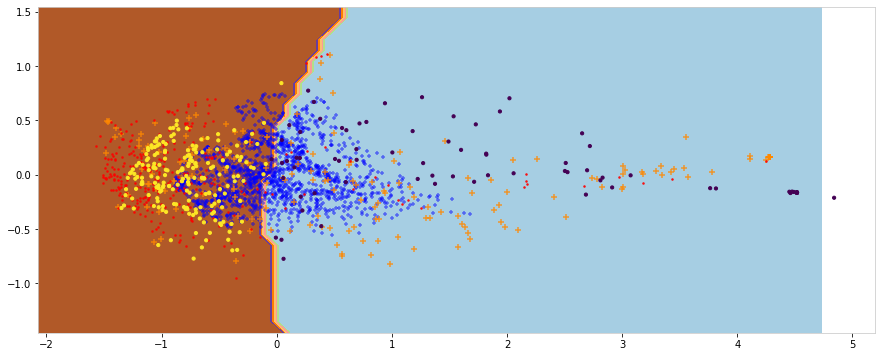

In [159]:
min1, max1 = xt[:,0].min()-0.5, xt[:,0].max()+0.5
min2, max2 = xt[:,1].min()-0.5, xt[:,1].max()+0.5
# define the x and y scale
x1grid = np.arange(min1, max1, 0.1)
x2grid = np.arange(min2, max2, 0.1)
# create all of the lines and rows of the grid
xx, yy = np.meshgrid(x1grid, x2grid)
# flatten each grid to a vector
r1, r2 = xx.flatten(), yy.flatten()
r1, r2 = r1.reshape((len(r1), 1)), r2.reshape((len(r2), 1))
# horizontal stack vectors to create x1,x2 input for the model
grid = np.hstack((r1,r2))
yhat = est.predict(grid)
zz = yhat.reshape(xx.shape)

plt.figure(figsize=(15,6))

plt.contourf(xx, yy, zz, cmap='Paired')

plt.scatter(comp3[:,0], comp3[:,1], label="Synthetic Healthy", alpha=0.5, s=10, marker="+", color="#0000FF")
plt.scatter(mb_synth_ns[:,0], mb_synth_ns[:,1], label="Synthetic IS (no lesion)", alpha=0.8, s=30, marker="+", color="#FF8800")
plt.scatter(mb_synth_stroke[:,0], mb_synth_stroke[:,1], label="Synthetic IS", alpha=0.8, s=10, marker=".", color="#FF0000")

p = est.predict(comptest)
#plt.scatter(comptest[:,0], comptest[:,1], label="Synthetic IS test", alpha=1, s=10, marker=".", color="#000000")
#print(p)

plt.scatter(comptest[:,0], comptest[:,1], c=p, s=10)

plt.savefig("plot-boundaries-v1-e"+str(ep)+"-xxxxxx.pdf", bbox_inches="tight")


fake = est.predict(df[["x","y"]])
print(accuracy_score(df[["class"]],fake))

## Healthy (anomaly approach)

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os

#d = pd.read_csv("data/xxx2.csv")

#mb_list = []
#mb_synth_ns = []
#mb_synth_stroke = []

#print(type(comp))
#for i in range(len(opt['trainA_image_names'])):
#    #fname, comp[i,0], comp[i,1], maskbin
#    #mb_list.append(list(d.loc[d["CT"] == opt['trainA_image_names'][i]]["maskbin"])[0])
#    #if (list(d.loc[d["CT"] == opt['trainA_image_names'][i]]["maskbin"])[0]==0):
#    #    mb_synth_ns.append([comp[i,0], comp[i,1]])
#    #else:
#        mb_synth_stroke.append([comp[i,0], comp[i,1]])

#mb_synth_ns = np.array(mb_synth_ns)
#mb_synth_stroke = np.array(mb_synth_stroke)

#d = {'files': opt["trainA_image_names"], 'maskbin': mb_list, 'x_pca': comp[:,0], 'y_pca': comp[:,1]}
#d = pd.DataFrame(data=d)

#sns.set(rc={'figure.figsize':(10,4)})
#sns.set_style("dark")
#sns.scatterplot(data=d, x="x_umap", y="y_umap", hue="maskbin", alpha=0.6)
sns.reset_defaults()
plt.figure(figsize=(10,4))
plt.rcParams['axes.edgecolor'] = '#CCCCCC'
#plt.scatter(comp3[:,0], comp3[:,1], label="Synthetic Healthy", alpha=0.3, s=40, marker="x", color="#00BB00")



plt.scatter(comp[:,0], comp[:,1], label="Synthetic Healthy", alpha=0.6, s=40, color="#0000FF", marker="+")
#plt.scatter(mb_synth_stroke[:,0], mb_synth_stroke[:,1], label="1 (stroke) Synthetic", alpha=0.6, s=100, marker=".", color="#FF6600")
#plt.scatter(mb_synth_ns[:,0], mb_synth_ns[:,1], label="0 (no mask) Synthetic", alpha=0.7, s=50, marker="+", color="#FF0000")
#plt.scatter(comp4[:,0], comp4[:,1], label="Synthetic IS", alpha=0.8, s=12, color="#FF6600")
plt.scatter(comp_foscal[:,0], comp_foscal[:,1], label="Synthetic IS (FOSCAL)", alpha=0.8, s=12, color="#FF6600")
#plt.scatter(comp_isles2018[:,0], comp_isles2018[:,1], label="Synthetic IS (isles 2018)", alpha=0.8, s=12, color="#FF0000")
#plt.scatter(comp_isles2018_testB[:,0], comp_isles2018_testB[:,1], label="Synthetic IS (isles 2018 test)", alpha=0.8, s=12, color="#FF00FF")
#plt.xticks(np.arange(-3, 20, 1))
plt.legend(framealpha=0.5)
plt.xticks([], [])
plt.yticks([], [])
#plt.savefig("plot01.pdf", bbox_inches="tight")
plt.savefig("plot02.pdf", bbox_inches="tight")
plt.show()

## PCA 3 COMPONENTS

### UMAP

(502, 1, 1, 512)
(1568, 1, 1, 512)
c_ch [ 1.0972277  -0.37663615]
c_s [ 3.941779   -0.39435714]
c_ns [1.2221311 0.7700564]
c [ 2.087046e+00 -3.122886e-04]


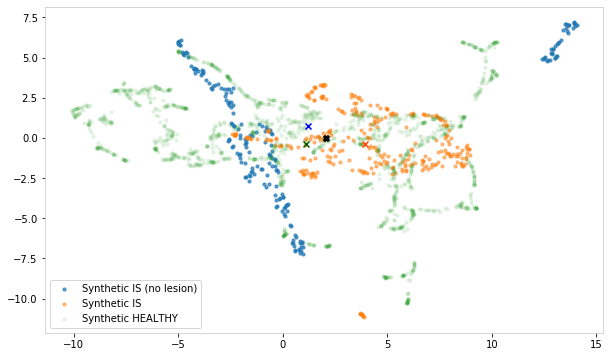

In [53]:
import umap

print(emb.shape)
#print(emb2.shape)
print(emb3.shape)

#um = umap.UMAP(random_state=0).fit_transform(emb[:,0,0,:])
#um2 = umap.UMAP(random_state=0).fit_transform(emb2[:,0,0,:])
um3 = umap.UMAP(random_state=0).fit_transform(emb3[:,0,0,:])
#um4 = umap.UMAP(random_state=0).fit_transform(emb4[:,0,0,:])

um_s = umap.UMAP(random_state=0).fit_transform(np.array(emb_s))
um_ns = umap.UMAP(random_state=0).fit_transform(np.array(emb_ns))

um_test = umap.UMAP(random_state=0).fit_transform(embtest[:,0,0,:])

plt.figure(figsize=(10,6))

c_ch = np.mean(um3, axis=0)
c_s = np.mean(um_s, axis=0)
c_ns = np.mean(um_ns, axis=0)
c = np.mean([c_ch, c_s, c_ns], axis=0)

print("c_ch", c_ch)
print("c_s", c_s)
print("c_ns", c_ns)
print("c", c)

#plt.scatter(um[:,0], um[:,1], label="Synthetic MRI", alpha=0.5)
plt.scatter(um_ns[:,0], um_ns[:,1], label="Synthetic IS (no lesion)", alpha=0.7, s=10)
plt.scatter(um_s[:,0], um_s[:,1], label="Synthetic IS", alpha=0.5, s=10)
plt.scatter(um3[:,0], um3[:,1], label="Synthetic HEALTHY", alpha=0.1, s=10)

#plt.scatter(um_test[:,0], um_test[:,1], label="Synthetic MRI test", alpha=0.5, s=10)

plt.scatter(c_ch[0], c_ch[1], marker="x", color="#006000")
plt.scatter(c_s[0], c_s[1], marker="x", color="#FF4400")
plt.scatter(c_ns[0], c_ns[1], marker="x", color="#0000FF")
plt.scatter(c[0], c[1], marker="X", color="#000000")

plt.legend()

plt.savefig("plot-umap-xxxx.pdf", bbox_inches="tight")
plt.show()

In [49]:
c_ch = np.mean(um3, axis=0)
c_s = np.mean(um_s, axis=0)
c_ns = np.mean(um_ns, axis=0)
#print("{0:.15f}".format(c_ch[1]), c_s[1], c_ns[1])
#print(c_ch, c_s)

c = np.mean([c_ch, c_s, c_ns], axis=0)

def distancia(u,v):
    #print(u, "{0:.15f}".format(v[0]), "{0:.15f}".format(v[1]))
    dif = u-v
    #print(dif)
    #print(np.sqrt(np.sum(np.power(dif, 2), axis=0)))
    return np.sqrt(np.sum(np.power(dif, 2), axis=0))

bss = um3.shape[0]*np.power(distancia(c,c_ch), 2) + um_s.shape[0]*np.power(distancia(c,c_s), 2) + um_ns.shape[0]*np.power(distancia(c,c_ns), 2)
print("BSS", bss, "=", str(um3.shape[0]*np.power(distancia(c,c_ch), 2)) +" + "+ str(um_s.shape[0]*np.power(distancia(c,c_s), 2)) +" + "+ str(um_ns.shape[0]*np.power(distancia(c,c_ns), 2)))

acum_ch = 0
for x in um3:
    acum_ch += np.power(distancia(x,c_ch), 2)
#print(acum_ch)
acum_s = 0
for x in um_s:
    acum_s += np.power(distancia(x,c_s), 2)
#print(acum_s)
acum_ns = 0
for x in um_ns:
    acum_ns += np.power(distancia(x,c_ns), 2)
#print(acum_ns)
print("WSS", acum_ch+acum_s+acum_ns, "=", str(acum_ch)+" + "+str(acum_s)+" + "+str(acum_ns))

print("|C_ch| =", um3.shape[0])
print("|C_s| =", um_s.shape[0])
print("|C_ns| =", um_ns.shape[0])

BSS 3121.3982919823584 = 1758.2918374129008 + 1100.163538884623 + 262.9429156848348
WSS 83045.99317855736 = 67919.1507824608 + 4353.1917576297055 + 10773.650638466863
|C_ch| = 1568
|C_s| = 306
|C_ns| = 196
